In [1]:
library(dplyr)
library(data.table)
library(ggpubr)

orf1ab_tbl <- data.table::fread("data/ORF1a__ORF1b_CDS.curated.csv", stringsAsFactors = FALSE)
orf1ab_tbl[11:16,]$Product <- substr(orf1ab_tbl$Note[11:16], 0, 5)

ordered_RBD_mutation_list <- c("A520S", "N501Y", "S477N", "L452R", "N501T", "S494P", "T478K", "K417N", "E484K", "E484Q", "K417T")
class1_epitope <- c(403, 405, 406, 417, 420, 421, 453, 455:460, 473:476, 486, 487, 489, 504)
class2_epitope <- c(472, 483:485, 490:494) 
class3_epitope <- c(345,346,437:452,496,498:501)
class4_epitope <- c(365:372, 382:386)

NTD_supersite_general <- c(
    14:19,
    140:158, #supersite β-hairpin
    161:162,
    245:264 # loop spanning residues 
)

NTD_supersite_specific <- c( # Table S5 https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7953435/#mmc1 
    14:19,
    140,
    143:148,
    150,
    152,
    154:156,
    158,
    161:162,
    244:256
)



Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


Loading required package: ggplot2

Loading required package: magrittr



In [5]:
fubar_output <- data.table::fread('data/selective_landscape/2022-09_hyphy_fubar_output.csv', stringsAsFactors = FALSE) %>%
    mutate(gene = if_else(gene=="S", "Spike", gene)) %>%
    mutate(protein = if_else(protein=="S", "Spike", protein)) %>%
    arrange(gene, site) 


In [6]:
gene_selection_summary_tbl <- data.table()
for(selected_gene in unique(fubar_output$gene[!is.na(fubar_output$gene)])){
    gene_width <- (fubar_output %>% filter(gene == selected_gene) %>% pull(site) %>% max()) 
    
    tmp <- fubar_output %>% 
            filter(gene == selected_gene) %>% 
            mutate(
                selection = case_when(
                    `Prob[alpha<beta]` >= 0.9 ~ "Positive",
                    `Prob[alpha>beta]` >= 0.9 ~ "Purifying",
                    (`Prob[alpha>beta]` < 0.9 & `Prob[alpha>beta]` < 0.9) ~ "None"
                )
            ) %>%
            count(selection) %>%
            mutate(
                prct = n / gene_width
            ) 
    
    gene_selection_summary_tbl <- rbind(
        gene_selection_summary_tbl,
        data.table(
            Gene = selected_gene,
            type = tmp$selection,
            n = tmp$n,
            prct = tmp$prct
        )
    )
    
}

gene_selection_summary_tbl <- rbind(
    gene_selection_summary_tbl,
    fubar_output %>% 
        filter(gene == "Spike" & site %in% 319:541) %>% 
        mutate(
            type = case_when(
                `Prob[alpha<beta]` >= 0.9 ~ "Positive",
                `Prob[alpha>beta]` >= 0.9 ~ "Purifying",
                (`Prob[alpha>beta]` < 0.9 & `Prob[alpha>beta]` < 0.9) ~ "None"
            )
        ) %>%
        count(type) %>%
        mutate(
            Gene = "Spike RBD",
            prct = n / (541 - 319 + 1)
        ),
    fubar_output %>% 
        filter(gene == "Spike" & site %in% 13:303) %>% 
        mutate(
            type = case_when(
                `Prob[alpha<beta]` >= 0.9 ~ "Positive",
                `Prob[alpha>beta]` >= 0.9 ~ "Purifying",
                (`Prob[alpha>beta]` < 0.9 & `Prob[alpha>beta]` < 0.9) ~ "None"
            )
        ) %>%
        count(type) %>%
        mutate(
            Gene = "Spike NTD",
            prct = n / (303 - 13 + 1)
        )
)


gene_selection_summary_tbl <- gene_selection_summary_tbl %>% 
    mutate(
        Gene = factor(Gene, levels = gene_selection_summary_tbl %>% filter(type == "Purifying") %>% arrange(prct) %>% pull(Gene))
    )
reshape::recast(gene_selection_summary_tbl, type~Gene , measure.var = "prct")


,type,ORF8,ORF10,ORF7a,ORF3a,E,ORF1a,ORF6,ORF1b,N,M,Spike NTD,Spike,Spike RBD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,None,0.75409836,0.7435897,0.80327869,0.6594203,0.7368421,0.77590909,0.79032258,0.74666172,0.6095238,0.69955157,0.6116838,0.64364207,0.6053812
2,Positive,0.16393443,0.1538462,0.06557377,0.2065217,0.1184211,0.05295455,0.03225806,0.03857567,0.1380952,0.04484305,0.1237113,0.07692308,0.1031390
3,Purifying,0.08196721,0.1025641,0.13114754,0.1340580,0.1447368,0.17113636,0.17741935,0.21476261,0.2523810,0.25560538,0.2646048,0.27943485,0.2914798


In [7]:
protein_selection_summary_tbl <- data.table()
for(selected_protein in unique(fubar_output$protein[!is.na(fubar_output$protein)])){
    if(selected_protein %in% orf1ab_tbl$Product){
        protein_width <- orf1ab_tbl %>% filter(Product == selected_protein) %>% pull(aa_width) %>% sum()
    }else{
        protein_width <- (fubar_output %>% filter(protein == selected_protein) %>% pull(site) %>% max()) 
    }
    
    tmp <- fubar_output %>% 
            filter(protein == selected_protein) %>% 
            mutate(
                selection = case_when(
                    `Prob[alpha<beta]` >= 0.9 ~ "Positive",
                    `Prob[alpha>beta]` >= 0.9 ~ "Purifying",
                    (`Prob[alpha>beta]` < 0.9 & `Prob[alpha>beta]` < 0.9) ~ "None"
                )
            ) %>%
            count(selection) %>%
            mutate(
                prct = n / protein_width
            ) 
    
    protein_selection_summary_tbl <- rbind(
        protein_selection_summary_tbl,
        data.table(
            Protein = selected_protein,
            type = tmp$selection,
            n = tmp$n,
            prct = tmp$prct
        )
    )
    
}

protein_selection_summary_tbl <- rbind(
    protein_selection_summary_tbl,
    fubar_output %>% 
        filter(protein == "Spike" & site %in% 319:541) %>% 
        mutate(
            type = case_when(
                `Prob[alpha<beta]` >= 0.9 ~ "Positive",
                `Prob[alpha>beta]` >= 0.9 ~ "Purifying",
                (`Prob[alpha>beta]` < 0.9 & `Prob[alpha>beta]` < 0.9) ~ "None"
            )
        ) %>%
        count(type) %>%
        mutate(
            Protein = "Spike RBD",
            prct = n / (541 - 319 + 1)
        ),
    fubar_output %>% 
        filter(protein == "Spike" & site %in% 13:303) %>% 
        mutate(
            type = case_when(
                `Prob[alpha<beta]` >= 0.9 ~ "Positive",
                `Prob[alpha>beta]` >= 0.9 ~ "Purifying",
                (`Prob[alpha>beta]` < 0.9 & `Prob[alpha>beta]` < 0.9) ~ "None"
            )
        ) %>%
        count(type) %>%
        mutate(
            Protein = "Spike NTD",
            prct = n / (303 - 13 + 1)
        )
)


protein_selection_summary_tbl <- protein_selection_summary_tbl %>% 
    mutate(
        Protein = factor(Protein, levels = protein_selection_summary_tbl %>% filter(type == "Purifying") %>% arrange(prct) %>% pull(Protein))
    )
reshape::recast(protein_selection_summary_tbl, type~Protein , measure.var = "prct")


,type,ORF8,ORF10,ORF7a,ORF3a,nsp2,E,nsp3,nsp15,nsp1,⋯,nsp7,nsp8,nsp13,nsp16,N,M,Spike NTD,Spike,nsp9,Spike RBD
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,None,0.75409836,0.7435897,0.80327869,0.6594203,0.76959248,0.7368421,0.80205656,0.82658960,0.76111111,⋯,0.73493976,0.73737374,0.72545757,0.68791946,0.6095238,0.69955157,0.6116838,0.64364207,0.67256637,0.6053812
2,Positive,0.16393443,0.1538462,0.06557377,0.2065217,0.08777429,0.1184211,0.05244216,0.02601156,0.08333333,⋯,0.02409639,0.02020202,0.03161398,0.06711409,0.1380952,0.04484305,0.1237113,0.07692308,0.04424779,0.1031390
3,Purifying,0.08196721,0.1025641,0.13114754,0.1340580,0.14263323,0.1447368,0.14550129,0.14739884,0.15000000,⋯,0.24096386,0.24242424,0.24292845,0.24496644,0.2523810,0.25560538,0.2646048,0.27943485,0.28318584,0.2914798


# Make figures

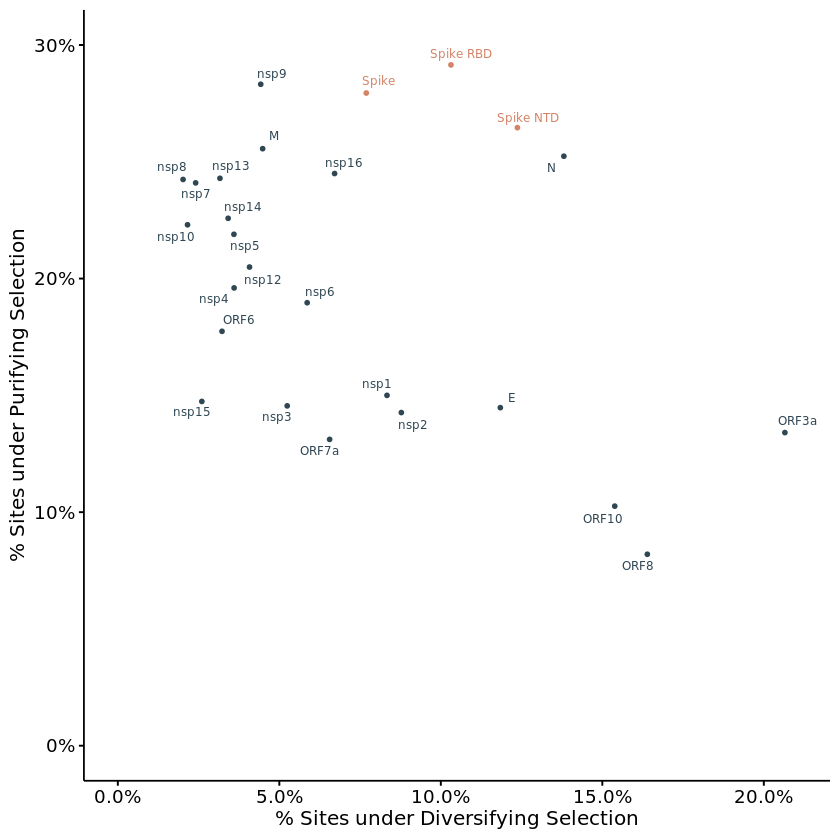

In [11]:
figure2b_df <- reshape::recast(protein_selection_summary_tbl, Protein~type , measure.var = "prct") %>% 
    mutate(
        col = grepl("Spike", Protein),
        Positive = case_when(
            !is.na(Positive) ~ Positive,
            is.na(Positive) ~ 0
        )
    )

figure2b <- figure2b_df %>%
    ggscatter(
        x = "Positive",
        y = "Purifying",
        size = 0.95,
        color = "col"
    ) + 
    ggrepel::geom_text_repel(
        data = figure2b_df %>% 
            mutate(col = grepl("Spike", Protein)),
        aes(
            label = Protein,
            color = col
        ),
        size = 2.5
    )  + 
    scale_color_manual(values = c("#2f4653", "#d48367")) +
    scale_x_continuous(labels = scales::percent, limits = c(0, 0.21)) + 
    scale_y_continuous(labels = scales::percent, limits = c(0, 0.3)) +
    xlab("% Sites under Diversifying Selection") +
    ylab("% Sites under Purifying Selection") +
    theme( 
        axis.text.x = element_text( size= 11, colour = "black" ), #,   angle = -50 , vjust = 0.4 , hjust = 0.1),
        axis.text.y = element_text(size= 11, colour = "black"),
        axis.title.y = element_text(size = 12),
        axis.title.x = element_text(size = 12),
        legend.position = "none"
    )

figure2b


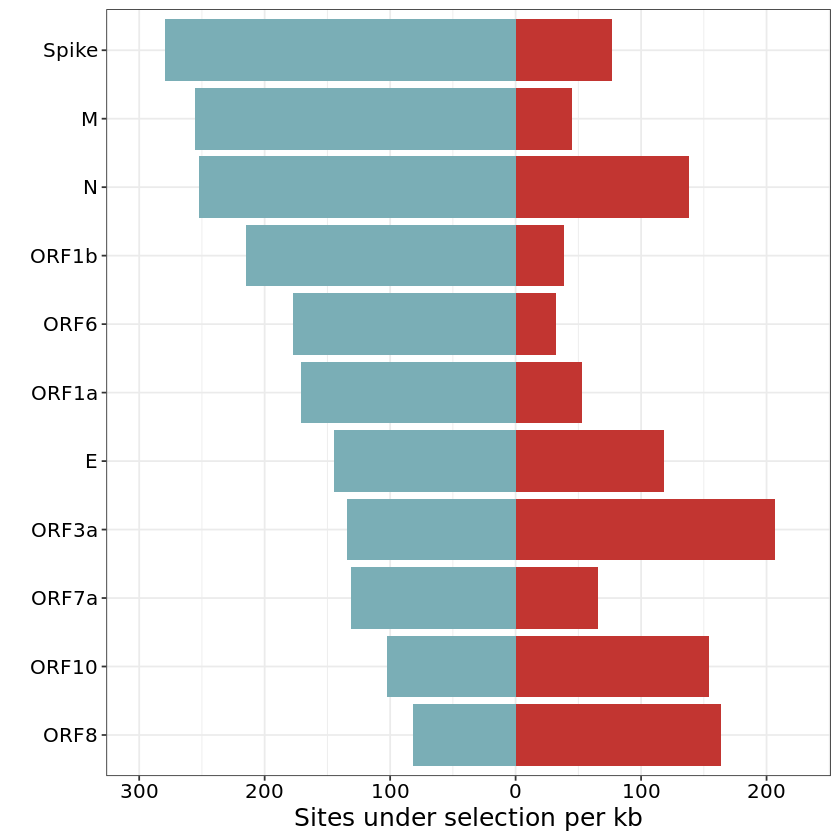

In [13]:
figure2a_df <- gene_selection_summary_tbl %>%
    filter(type != "None") %>%
    rename(
        selection = type
    ) %>%
    mutate(
        scaled_n = prct * 1000,
        scaled_n = case_when(
          selection == "Positive" ~ scaled_n,
          selection == "Purifying" ~ -1 * scaled_n
        )
  ) %>%
  arrange(desc(scaled_n)) 

figure2a <- figure2a_df %>%
    filter(!grepl("RBD|NTD", Gene)) %>%
    mutate(gene = factor(Gene, levels = figure2a_df %>% filter(selection == "Purifying") %>% pull(Gene))) %>%
    ggplot(aes(x = Gene, y = scaled_n, fill = selection)) + 
    geom_bar(stat = "identity") +
    coord_flip() + 
    labs(
       # title = "Gene-Level\nSelection",
        y = 'Sites under selection per kb',
        x = ''
    ) +
    scale_fill_manual(name = "", values = c('#c23531','#7aaeb6'))+
    theme_bw() +
    scale_y_continuous(limits = c(-300, 225), breaks = seq(-300, 225, by = 100), labels = paste0(abs(seq(-300, 225, by = 100)))) +
    theme(
        axis.title.x = element_text(size = 15),
        axis.text.x = element_text( size= 12, colour = "black" ),
        axis.text.y = element_text( size= 12, colour = "black" ),
        legend.position = "none"
    ) 

figure2a


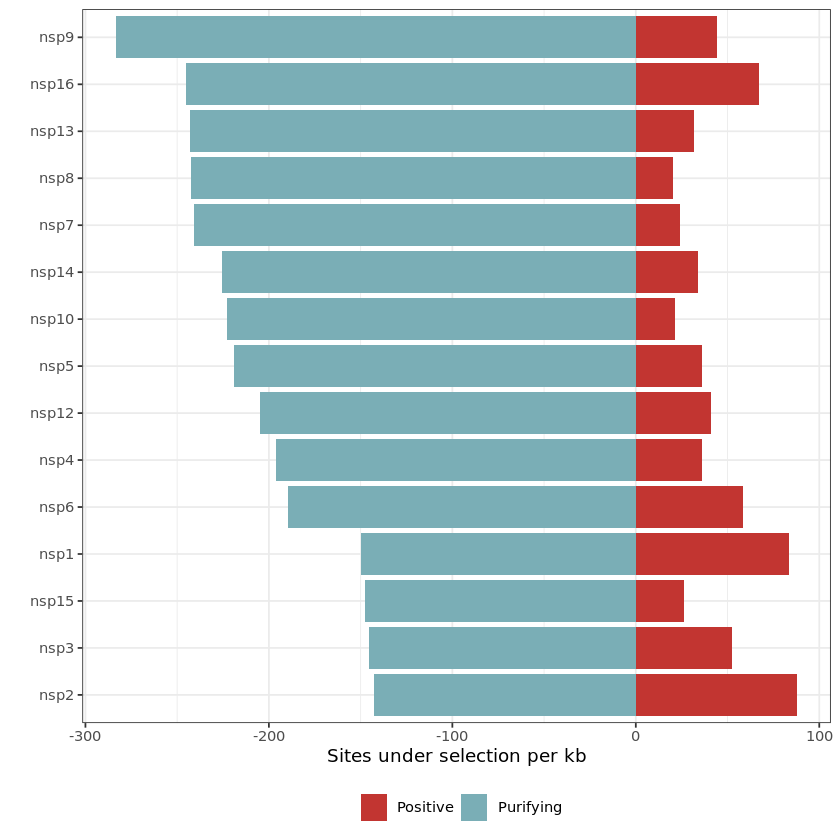

In [19]:
figS1a_df <- fubar_output %>%
    filter(gene %in% c("ORF1a", "ORF1b")) %>%
    mutate(
        selection = case_when(
          (alpha < beta) & `Prob[alpha<beta]` > 0.9 ~ "Positive",
          (alpha >= beta) & `Prob[alpha>beta]` > 0.9 ~ "Purifying"
        )
    ) %>%
    filter(!is.na(selection)) %>%
    dplyr::count(selection, protein) %>%
    mutate(
        size = sapply(protein, function(x) orf1ab_tbl %>% filter(Product == x) %>% pull(aa_width) %>% sum()),
        scaled_n = as.numeric(n)/size *1000,
        scaled_n = case_when(
          selection == "Positive" ~ scaled_n,
          selection == "Purifying" ~ -1 * scaled_n
        )
    ) %>%
    arrange(desc(scaled_n)) 


figS1a <- figS1a_df %>%
    mutate(
        protein = factor(
            protein, 
            levels = figS1a_df %>% 
                    filter(selection == "Purifying") %>% 
                    pull(protein)
        )
    ) %>%
    ggplot(
        aes(
            x = protein, 
            y = scaled_n, 
            fill = selection
        )
    ) + 
    geom_bar(stat = "identity") +
    coord_flip() + 
    labs(
        x = '',
        y = 'Sites under selection per kb'
    )+
    scale_fill_manual(name = "", values = c('#c23531','#7aaeb6'))+
    theme_bw() +
    theme(legend.position = "bottom")
      
figS1a

Warning message:
“Removed 437 rows containing missing values (geom_text).”


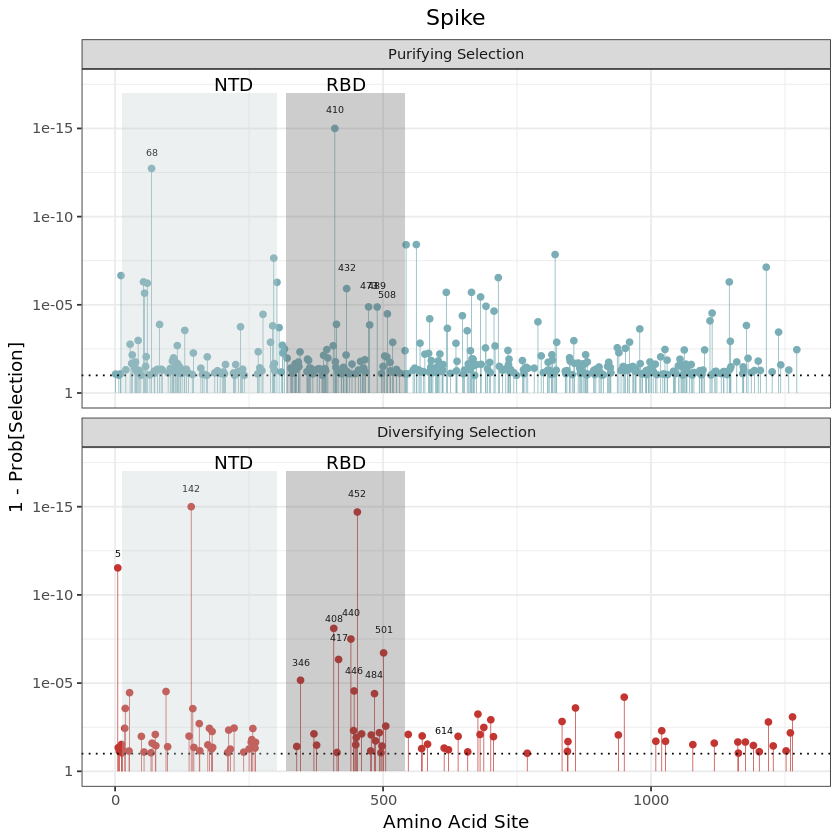

In [20]:
hide_sites <- c(302, 681)

figure2c <- fubar_output %>%
    filter(
    gene == "Spike" &
      (`Prob[alpha<beta]` > 0.9 | `Prob[alpha>beta]` > 0.9)
    ) %>%
    mutate(
        selection = case_when(
          alpha < beta ~ "Diversifying Selection",
          alpha >= beta ~ "Purifying Selection"
        ),
        p = case_when(
          `Prob[alpha>beta]` > `Prob[alpha<beta]` ~ `Prob[alpha>beta]`,
          `Prob[alpha>beta]` <= `Prob[alpha<beta]` ~ `Prob[alpha<beta]`
        ),
        p = -1* log10(1 - p),
        p = case_when(
            p == Inf ~ 15,
            p != Inf ~ p
        ),
        label = case_when(
          # diversifying
          site == 614 ~ site,
          p > 3 & (selection == "Diversifying Selection") & (site %in% 319:541)  & !(site %in% hide_sites) ~ site,
          p > 4 & (selection == "Purifying Selection") & (site %in% 319:541)  & !(site %in% hide_sites) ~ site,
          p > 5 & (selection == "Diversifying Selection")  & !(site %in% hide_sites)  ~ site,
          p > 9 & (selection == "Purifying Selection") & !(site %in% hide_sites) ~ site
        ),
        label_pos = case_when(
            site == 614 ~ p * 1.75,
            site == 477 ~ p * 1.5,
            p > 8 ~ p * 1.07,
            p > 5 ~ p * 1.2,
            p > 3 ~ p * 1.25
        ),
        selection = factor(selection, levels = c("Purifying Selection", "Diversifying Selection"))
    ) %>%
    arrange(desc(selection)) %>%
    ggplot(aes(site, p)) + 
    geom_point(aes(color = ifelse(alpha < beta, '1', '2'))) + 
    geom_linerange(aes(ymin = 0, ymax = p, color = ifelse(alpha < beta, '1', '2')),size = 0.2) + 
    geom_text(aes(x = site, y = label_pos, label = label), cex = 2) +
    scale_color_manual(name = "", values = c('#c23531','#7aaeb6')) +
    xlab('Amino Acid Site') + 
    ylab('1 - Prob[Selection]') + 
    ggtitle("Spike") +
    facet_wrap(.~selection, ncol = 1) + 
    theme_bw() +
    theme(
        plot.title = element_text(hjust = 0.5),
        legend.position= "none" 
    ) + 
   scale_y_continuous(breaks = c(0, 5, 10, 15), labels = paste0(c(10^(-1*c(0,5,10,15))))) +
    geom_hline(yintercept = 1,linetype = 'dotted') + 
    annotate('rect',xmin=13, xmax=303, ymin=0, ymax=17, alpha=0.3, fill = "azure3") +
    annotate('text', x = (303-13)/2 + 75, y = 17.5, label = 'NTD') + 
    annotate('rect',xmin=319, xmax=541, ymin=0, ymax=17, alpha=0.3) +
    annotate('text', x = 319+(541-319)/2, y = 17.5, label = 'RBD')

# 14 to 26), N2 (residues 67 to 79), N3 (residues 141 to 156), N4 (residues 177 to 186), and N5 (residues 246 to 260

figure2c
